In [72]:
import pandas as pd
import hvplot.pandas
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import requests
import json
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [73]:
# Using the read_csv function and Path module, create a DataFrame 
# by importing the file from the Resources folder
Copper_df = pd.read_csv(
    Path('Resources/Copper.csv'),
    index_col='DATE',
    infer_datetime_format=True, 
    parse_dates=True
)
Nickel_df = pd.read_csv(
    Path('Resources/Nickel.csv'),
    index_col='DATE',
    infer_datetime_format=True, 
    parse_dates=True
)
Zinc_df = pd.read_csv(
    Path('Resources/Zinc.csv'),
    index_col='DATE',
    infer_datetime_format=True, 
    parse_dates=True
)


# Review the first and last five rows of the DataFrame

Copper_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 383 entries, 1990-01-01 to 2021-11-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PCOPPUSDM  383 non-null    float64
dtypes: float64(1)
memory usage: 6.0 KB


In [74]:
Nickel_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 383 entries, 1990-01-01 to 2021-11-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PNICKUSDM  383 non-null    float64
dtypes: float64(1)
memory usage: 6.0 KB


In [75]:
Zinc_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 383 entries, 1990-01-01 to 2021-11-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PZINCUSDM  383 non-null    float64
dtypes: float64(1)
memory usage: 6.0 KB


In [76]:
Copper_df.isna().any().sum()
Nickel_df.isna().any().sum()
Zinc_df.isna().any().sum()

0

In [77]:
Commodities_list = [Copper_df, Nickel_df, Zinc_df]
Commodities_df =pd.concat([Copper_df, Nickel_df, Zinc_df],axis=1)
display(Commodities_df)
Commodities_df.info()

,PCOPPUSDM,PNICKUSDM,PZINCUSDM
DATE,,,
1990-01-01,2365.556991,7056.00000,1294.000000
1990-02-01,2358.943400,6977.00000,1394.000000
1990-03-01,2625.702723,9267.00000,1666.000000
1990-04-01,2685.226891,8939.00000,1686.000000
1990-05-01,2740.342391,8698.00000,1775.000000
...,...,...,...
2021-07-01,9450.820455,18818.51136,2947.517273
2021-08-01,9370.138571,19141.29667,2987.947143
2021-09-01,9324.709545,19376.87500,3036.018636


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 383 entries, 1990-01-01 to 2021-11-01
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PCOPPUSDM  383 non-null    float64
 1   PNICKUSDM  383 non-null    float64
 2   PZINCUSDM  383 non-null    float64
dtypes: float64(3)
memory usage: 12.0 KB


In [78]:
Commodities_df.rename(columns={'PCOPPUSDM': 'Copper', 'PNICKUSDM': 'Nickel', 'PZINCUSDM': 'Zinc'}, inplace=True)
display(Commodities_df)

,Copper,Nickel,Zinc
DATE,,,
1990-01-01,2365.556991,7056.00000,1294.000000
1990-02-01,2358.943400,6977.00000,1394.000000
1990-03-01,2625.702723,9267.00000,1666.000000
1990-04-01,2685.226891,8939.00000,1686.000000
1990-05-01,2740.342391,8698.00000,1775.000000
...,...,...,...
2021-07-01,9450.820455,18818.51136,2947.517273
2021-08-01,9370.138571,19141.29667,2987.947143
2021-09-01,9324.709545,19376.87500,3036.018636


In [79]:
# Compute the `monthly_returns_df` DataFrame by chaining
# the pct_change function with the dropna function.
Monthly_Returns_df = Commodities_df.pct_change().dropna()
Monthly_Returns_df

,Copper,Nickel,Zinc
DATE,,,
1990-02-01,-0.002796,-0.011196,0.077280
1990-03-01,0.113084,0.328221,0.195122
1990-04-01,0.022670,-0.035394,0.012005
1990-05-01,0.020525,-0.026961,0.052788
1990-06-01,-0.057120,-0.031731,-0.033803
...,...,...,...
2021-07-01,-0.018759,0.046661,-0.001469
2021-08-01,-0.008537,0.017153,0.013717
2021-09-01,-0.004848,0.012307,0.016088


In [80]:
Monthly_Returns_df.describe()

,Copper,Nickel,Zinc
count,382.000000,382.000000,382.000000
mean,0.005530,0.005808,0.004336
std,0.060198,0.078993,0.061061
min,-0.298235,-0.317008,-0.253088
25%,-0.026170,-0.048926,-0.030183
50%,0.005192,-0.001535,0.003016
75%,0.036564,0.057991,0.040769
max,0.258375,0.328221,0.263915


In [81]:
# Load the environment variables by calling the load_dotenv function
load_dotenv()

True

In [82]:
# Set Alpaca API key and secret by calling the os.getenv function and referencing the environment variable names
# Set each environment variable to a notebook variable of the same name
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Check the values were imported correctly by evaluating the type of each
display(type(alpaca_api_key))
display(type(alpaca_secret_key))

str

str

In [83]:
# Create your Alpaca API REST object by calling Alpaca's tradeapi.REST function
# Set the parameters to your alpaca_api_key, alpaca_secret_key and api_version="v2" 
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [84]:
# Create the list for the required tickers
tickers = ["COST", "XLP","VDC","PG"]

In [85]:
# Set the values for start_date and end_date using the pd.Timestamp function
# The start and end data should be 
# Set the parameter tz to "America/New_York", 
# Set this all to the ISO format by calling the isoformat function 
start_date = pd.Timestamp("2018-01-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-11-01", tz="America/New_York").isoformat()

In [86]:
# Set timeframe to one day (1D)
timeframe = "1D"

# Set number of rows to 1000 to retrieve the maximum amount of rows
limit_rows = 1000

In [87]:
# Use the Alpaca get_barset function to gather the price information for each ticker
# Include the function parameters: tickers, timeframe, start, end, and limit
# Be sure to call the df property to ensure that the returned information is set as a DataFrame
prices_df = alpaca.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=limit_rows,
).df

# Review the first five rows of the resulting DataFrame 
prices_df.head()

COST                                        PG  \
                             open     high      low   close   volume   open   
time                                                                          
2018-01-02 00:00:00-05:00  187.19  190.680  186.750  188.36  1746783  91.92   
2018-01-03 00:00:00-05:00  188.52  192.100  188.380  190.61  2258752  90.98   
2018-01-04 00:00:00-05:00  192.00  192.300  187.561  189.12  2566125  90.83   
2018-01-05 00:00:00-05:00  189.43  189.680  186.720  187.75  2000923  91.15   
2018-01-08 00:00:00-05:00  187.32  188.979  187.250  188.47  1126558  90.93   

                                                             VDC            \
                            high     low  close   volume    open      high   
time                                                                         
2018-01-02 00:00:00-05:00  91.93  90.550  90.66  5257189  146.16  146.3200   
2018-01-03 00:00:00-05:00  91.09  90.515  90.57  3976843  145.42  145.7000   
2018-01-04 00:00:00-05:00  91.77  90.610  91.18  4316526  145.42  146.2818   
2018-01-05 00:00:00-05:00  91.30  90.570  91.19  3848619  145.98  146.2242   
2018-01-08 00:00:00-05:00  91.77  90.930  91.71  3298886  146.16  146.6100   

                                                         XLP                   \
                                low   close    volume   open     high     low   
time                                                                            
2018-01-02 00:00:00-05:00  145.2684  145.29  171020.0  56.95  57.0200  56.530   
2018-01-03 00:00:00-05:00  145.1111  145.20  100558.0  56.63  56.7200  56.470   
2018-01-04 00:00:00-05:00  145.3002  145.60  316349.0  56.67  56.9453  56.530   
2018-01-05 00:00:00-05:00  145.4900  146.18  102662.0  56.77  56.9667  56.635   
2018-01-08 00:00:00-05:00  146.0010  146.59   99092.0  56.85  57.1200  56.820   

                                            
                           close    volume  
time                                        
2018-01-02 00:00:00-05:00  56.57  11288883  
2018-01-03 00:00:00-05:00  56.52   9795436  
2018-01-04 00:00:00-05:00  56.69   7205552  
2018-01-05 00:00:00-05:00  56.94   7524295  
2018-01-08 00:00:00-05:00  57.07   6560047

In [88]:
stocks_monthly=prices_df.resample('MS').last()
stocks_monthly.head()


COST                                          PG  \
                             open      high       low   close   volume   open   
time                                                                            
2018-01-01 00:00:00-05:00  197.87  198.4747  194.1000  194.88  1723240  86.81   
2018-02-01 00:00:00-05:00  191.60  193.7600  190.8900  190.90  1228694  80.68   
2018-03-01 00:00:00-05:00  184.74  188.6400  184.4100  187.86  1438633  79.43   
2018-04-01 00:00:00-04:00  197.10  199.0400  196.3852  197.19  1117964  72.91   
2018-05-01 00:00:00-04:00  200.21  200.6972  197.7000  198.25  2802111  74.67   

                                                                VDC            \
                             high      low  close    volume    open      high   
time                                                                            
2018-01-01 00:00:00-05:00  87.410  86.0750  86.38   7246937  149.38  149.6499   
2018-02-01 00:00:00-05:00  80.790  78.5000  78.52  11284842  139.42  139.6000   
2018-03-01 00:00:00-05:00  80.490  79.1799  79.28   7289155  135.72  136.8699   
2018-04-01 00:00:00-04:00  72.915  72.1600  72.33   7806891  132.13  132.7370   
2018-05-01 00:00:00-04:00  74.690  72.8000  73.15   7705467  131.24  131.2400   

                                                         XLP                   \
                               low    close    volume   open     high     low   
time                                                                            
2018-01-01 00:00:00-05:00  147.950  148.550  189536.0  58.14  58.2900  57.585   
2018-02-01 00:00:00-05:00  137.569  137.569   64497.0  54.29  54.3200  53.410   
2018-03-01 00:00:00-05:00  135.590  136.150  134563.0  52.48  52.9501  52.480   
2018-04-01 00:00:00-04:00    0.000  131.080   92090.0  50.86  51.0852  50.360   
2018-05-01 00:00:00-04:00  129.100  129.600  216627.0  50.38  50.4300  49.470   

                                            
                           close    volume  
time                                        
2018-01-01 00:00:00-05:00  57.83  12284388  
2018-02-01 00:00:00-05:00  53.41  10943106  
2018-03-01 00:00:00-05:00  52.63  12805795  
2018-04-01 00:00:00-04:00  50.45  12479239  
2018-05-01 00:00:00-04:00  49.67  17843563

In [89]:
stocks_close_df=stocks_monthly.xs("close",level=1,axis="columns")
stocks_close_df.head()

,COST,PG,VDC,XLP
time,,,,
2018-01-01 00:00:00-05:00,194.88,86.38,148.550,57.83
2018-02-01 00:00:00-05:00,190.90,78.52,137.569,53.41
2018-03-01 00:00:00-05:00,187.86,79.28,136.150,52.63
2018-04-01 00:00:00-04:00,197.19,72.33,131.080,50.45
2018-05-01 00:00:00-04:00,198.25,73.15,129.600,49.67


In [90]:
stocks_close_df.index = stocks_close_df.index.date



In [91]:
df=pd.concat([Commodities_df,stocks_close_df],axis=1)

In [92]:
df.dropna()

,Copper,Nickel,Zinc,COST,PG,VDC,XLP
2018-01-01,7065.852273,12864.87500,3441.522727,194.8800,86.380,148.5500,57.8300
2018-02-01,7006.525000,13595.87500,3532.900000,190.9000,78.520,137.5690,53.4100
2018-03-01,6799.178571,13392.50000,3269.178571,187.8600,79.280,136.1500,52.6300
2018-04-01,6851.512500,13938.10000,3188.050000,197.1900,72.330,131.0800,50.4500
2018-05-01,6825.273810,14366.48810,3059.869048,198.2500,73.150,129.6000,49.6700
2018-06-01,6965.857143,15105.65476,3088.571429,209.0300,78.070,134.2500,51.5100
2018-07-01,6250.750000,13793.86364,2656.125000,218.7200,80.880,138.9200,53.5600
2018-08-01,6051.045455,13411.35227,2512.000000,233.1400,82.930,140.0896,53.8100
2018-09-01,6050.762500,12510.35000,2434.675000,234.8900,83.220,140.1500,53.9200
2018-10-01,6219.586957,12314.91304,2673.673913,228.6300,88.660,142.4800,55.0400


In [93]:
df.corr()

,Copper,Nickel,Zinc,COST,PG,VDC,XLP
Copper,1.000000,0.756631,0.836276,0.695988,0.483730,0.779058,0.728068
Nickel,0.756631,1.000000,0.733930,0.794215,0.649627,0.814884,0.789761
Zinc,0.836276,0.733930,1.000000,0.061106,-0.181601,0.170074,0.110052
COST,0.695988,0.794215,0.061106,1.000000,0.910465,0.939177,0.941463
PG,0.483730,0.649627,-0.181601,0.910465,1.000000,0.897285,0.923665
VDC,0.779058,0.814884,0.170074,0.939177,0.897285,1.000000,0.996209
XLP,0.728068,0.789761,0.110052,0.941463,0.923665,0.996209,1.000000


<AxesSubplot:>

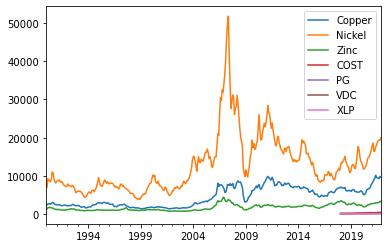

In [94]:
df.plot()

In [96]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)